# 09-03. LSTM과 GRU 셀
- 기본 순환층에서 은닉 상태에 담긴 정보가 희석되는 문제를 해결하기 위해 발명된 셀

## LSTM(Long Short-Term Memory) 구조
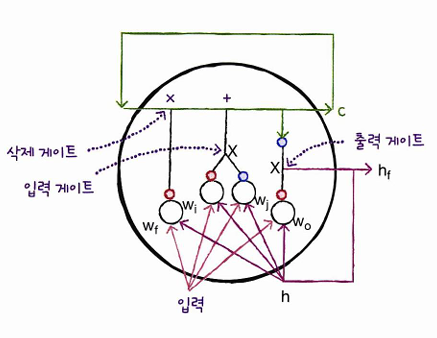
- 단기기억을 오래 기억하기 위해 고안된 구조
- 빨간 원은 시그모이드 함수, 파란 원은 tahn 활성화 함수
- 셀 상태: 다음 층으로 전달되지 않고 셀 내에서 순환하는 값
  - 삭제 게이트: 셀 상태에 있는 정보를 제거하는 역할
  - 입력 게이트: 셀 상태에 새로운 정보를 추가하는 역할
  - 출력 게이트: 셀 상태를 다음 은닉 상태로 출력시키는 역할

### LSTM 신경망 훈련하기

In [1]:
# IMDB 리뷰 데이터 적재 및 분할

from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=500)
train_input, val_input, train_target, val_target = train_test_split(train_input, train_target, test_size=0.2, random_state=42)

In [2]:
# 샘플의 길이 통일

from tensorflow.keras.preprocessing.sequence import pad_sequences

train_seq = pad_sequences(train_input, maxlen=100)
val_seq = pad_sequences(val_input, maxlen=100)

In [3]:
# 모델 생성

from tensorflow import keras

model = keras.Sequential()
model.add(keras.layers.Embedding(500, 16, input_length=100))
model.add(keras.layers.LSTM(8))  # LSTM 클래스 사용
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.build(input_shape=(None, 100))  # input_shape을 명시하지 않으면 output shape이 ?로 출력되는 문제 해결을 위해 삽입
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           8000      
                                                                 
 lstm (LSTM)                 (None, 8)                 800       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 8809 (34.41 KB)
Trainable params: 8809 (34.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


- 작은 셀 4개를 사용하기 때문에 SimpleRNN 클래스에 비해 정확히 4배 많은 800개의 파라미터 사용

In [4]:
# 모델 컴파일, 훈련

rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-lstm-model.keras', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(train_seq, train_target, epochs=100, batch_size=64, validation_data=(val_seq, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 10s 28ms/step - loss: 0.6912 - accuracy: 0.5766 - val_loss: 0.6882 - val_accuracy: 0.6358
Epoch 2/100
313/313 [==============================] - 8s 27ms/step - loss: 0.6747 - accuracy: 0.6714 - val_loss: 0.6448 - val_accuracy: 0.7066
Epoch 3/100
313/313 [==============================] - 8s 27ms/step - loss: 0.6085 - accuracy: 0.7092 - val_loss: 0.5886 - val_accuracy: 0.7166
Epoch 4/100
313/313 [==============================] - 9s 28ms/step - loss: 0.5759 - accuracy: 0.7300 - val_loss: 0.5702 - val_accuracy: 0.7288
Epoch 5/100
313/313 [==============================] - 9s 28ms/step - loss: 0.5559 - accuracy: 0.7459 - val_loss: 0.5524 - val_accuracy: 0.7474
Epoch 6/100
313/313 [==============================] - 9s 29ms/step - loss: 0.5401 - accuracy: 0.7556 - val_loss: 0.5393 - val_accuracy: 0.7500
Epoch 7/100
313/313 [==============================] - 9s 29ms/step - loss: 0.5259 - accuracy: 0.7646 - val_loss: 0.5277 - val_accuracy

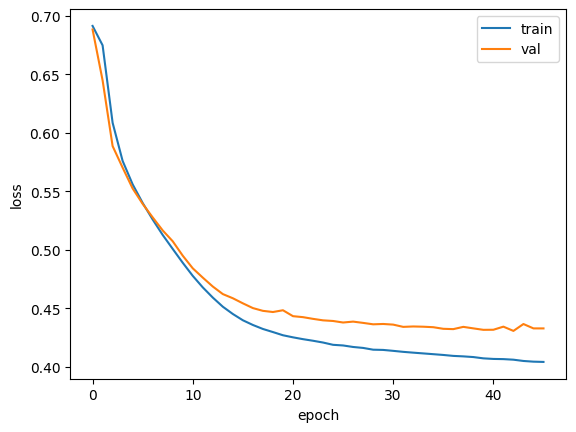

In [5]:
# 손실 그래프 그리기

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

- 기본 순환층보다 과대적합을 억제하면서 훈련을 잘 수행함

### 순환층에 드롭아웃 적용하기
- 순환층은 자체적으로 드롭아웃 기능을 제공
- dropout 매개변수와 recurrent_dropout 매개변수(GPU 사용 불가)를 지원

In [6]:
# 드롭아웃을 적용한 모델 생성

model2 = keras.Sequential()
model2.add(keras.layers.Embedding(500, 16, input_length=100))
model2.add(keras.layers.LSTM(8, dropout=0.3))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

In [7]:
# 모델 컴파일, 훈련

rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-lstm-model2.keras', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model2.fit(train_seq, train_target, epochs=100, batch_size=64, validation_data=(val_seq, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 11s 31ms/step - loss: 0.6926 - accuracy: 0.5375 - val_loss: 0.6920 - val_accuracy: 0.5742
Epoch 2/100
313/313 [==============================] - 9s 29ms/step - loss: 0.6908 - accuracy: 0.5861 - val_loss: 0.6893 - val_accuracy: 0.6210
Epoch 3/100
313/313 [==============================] - 9s 29ms/step - loss: 0.6856 - accuracy: 0.6249 - val_loss: 0.6794 - val_accuracy: 0.6474
Epoch 4/100
313/313 [==============================] - 9s 28ms/step - loss: 0.6579 - accuracy: 0.6652 - val_loss: 0.6295 - val_accuracy: 0.6842
Epoch 5/100
313/313 [==============================] - 9s 29ms/step - loss: 0.6161 - accuracy: 0.6898 - val_loss: 0.6020 - val_accuracy: 0.7058
Epoch 6/100
313/313 [==============================] - 10s 31ms/step - loss: 0.5939 - accuracy: 0.7140 - val_loss: 0.5837 - val_accuracy: 0.7224
Epoch 7/100
313/313 [==============================] - 9s 30ms/step - loss: 0.5780 - accuracy: 0.7278 - val_loss: 0.5679 - val_accurac

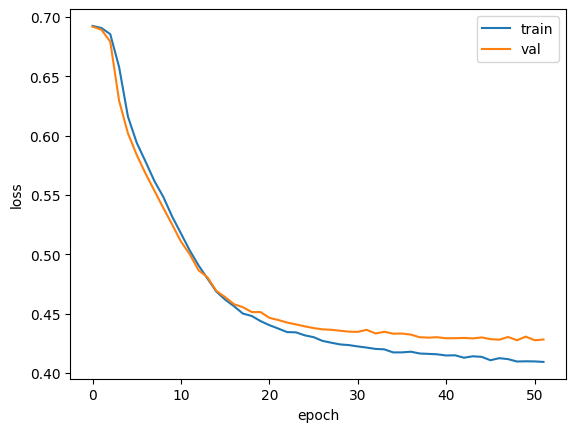

In [8]:
# 손실 그래프 그리기

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

- 드롭아웃이 적용되어 훈련 손실과 검증 손실 간 차이가 감소

### 2개의 층을 연결하기
- 2개 이상의 순환층을 연결하기 위해서는 마지막 순환층을 제외한 다른 순환층은 모든 타임스텝에 대한 은닉 상태를 출력해야함
- 순환층의 return_sequences 매개변수를 True로 지정하여 구현 가능

In [9]:
# 2개의 순환층을 연결한 모델 생성

model3 = keras.Sequential()
model3.add(keras.layers.Embedding(500, 16, input_length=100))
model3.add(keras.layers.LSTM(8, dropout=0.3, return_sequences=True))
model3.add(keras.layers.LSTM(8, dropout=0.3))
model3.add(keras.layers.Dense(1, activation='sigmoid'))
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 16)           8000      
                                                                 
 lstm_2 (LSTM)               (None, 100, 8)            800       
                                                                 
 lstm_3 (LSTM)               (None, 8)                 544       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 9353 (36.54 KB)
Trainable params: 9353 (36.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


- 첫 번째 LSTM 층은 모든 타임스텝(100개)의 은닉 상태를 출력하기 위해 (None, 100, 8)의 출력 크기를 가짐

In [10]:
# 모델 컴파일, 훈련

rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model3.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-lstm-model3.keras', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model3.fit(train_seq, train_target, epochs=100, batch_size=64, validation_data=(val_seq, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 20s 55ms/step - loss: 0.6930 - accuracy: 0.5123 - val_loss: 0.6929 - val_accuracy: 0.5064
Epoch 2/100
313/313 [==============================] - 17s 56ms/step - loss: 0.6925 - accuracy: 0.5487 - val_loss: 0.6922 - val_accuracy: 0.5468
Epoch 3/100
313/313 [==============================] - 17s 54ms/step - loss: 0.6911 - accuracy: 0.5878 - val_loss: 0.6897 - val_accuracy: 0.5946
Epoch 4/100
313/313 [==============================] - 18s 58ms/step - loss: 0.6831 - accuracy: 0.6355 - val_loss: 0.6700 - val_accuracy: 0.6604
Epoch 5/100
313/313 [==============================] - 17s 53ms/step - loss: 0.6290 - accuracy: 0.6799 - val_loss: 0.5944 - val_accuracy: 0.7002
Epoch 6/100
313/313 [==============================] - 17s 53ms/step - loss: 0.5718 - accuracy: 0.7205 - val_loss: 0.5541 - val_accuracy: 0.7308
Epoch 7/100
313/313 [==============================] - 16s 50ms/step - loss: 0.5419 - accuracy: 0.7430 - val_loss: 0.5281 - val_ac

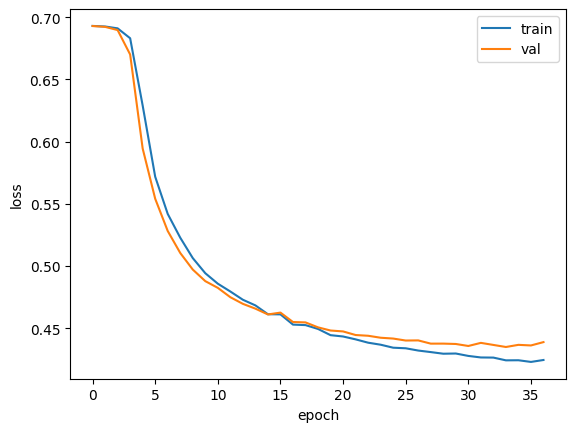

In [11]:
# 손실 그래프 그리기

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

- 과대적합을 제어하면서 손실을 최소화

## GRU(Gated Recurrent Unit) 구조
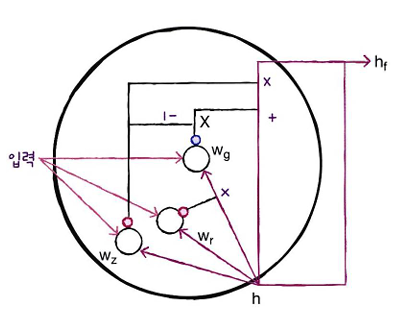
- LSTM 구조에서 셀 상태를 제외한 간소화된 버전
- LSTM보다 계산량이 적지만 좋은 성능을 가짐
- $w_z$셀의 출력이 은닉 상태와 곱해져 삭제 게이트 역할 수행
- $w_z$셀의 출력을 1에서 뺀 값이 $w_g$셀의 출력과 곱해져 입력 게이트 역할을 수행
- $w_r$셀의 출력이 $w_g$셀이 사용할 은닉 상태를 제어하는 역항을 수행

### 텐서플로에 구현된 GRU 셀
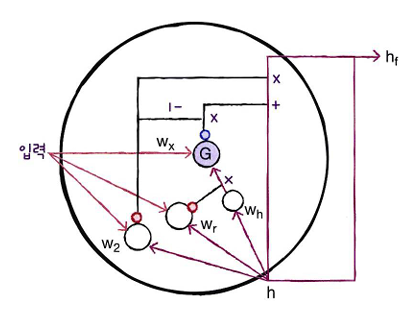
- G셀로 향하는 은닉 상태가 $w_r$셀의 출력과 곱해지기 전에 가중치 $w_h$와 곱해짐
- G셀로 향하는 입력은 가중치 $w_x$와 곱해짐
- 은닉 상태에 곱해지는 절편이 별도로 필요하기 때문에 3개의 파라미터가 추가됨

In [12]:
# GRU 신경망 모델 생성

model4 = keras.Sequential()
model4.add(keras.layers.Embedding(500, 16, input_length=100))
model4.add(keras.layers.GRU(8))
model4.add(keras.layers.Dense(1, activation='sigmoid'))
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 16)           8000      
                                                                 
 gru (GRU)                   (None, 8)                 624       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8633 (33.72 KB)
Trainable params: 8633 (33.72 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


- 하나의 GRU 셀에 3개이 작은 셀이 포함되어 있으므로 파라미터는 총 208 x 3 = 624개
  - 작은 셀의 입력에 곱하는 가중치 16 x 8 = 128개
  - 작은 셀의 은닉 상태에 곱하는 가중치 8 x 8 = 64개
  - 작은 셀의 절편 3 x 8 = 24개

In [13]:
# 모델 컴파일, 훈련

rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model4.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['acc'])
checkpoint_cb = keras.callbacks.ModelCheckpoint("best-gru-model.keras", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model4.fit(train_seq, train_target, epochs=100, batch_size=64, validation_data=(val_seq, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 12s 33ms/step - loss: 0.6928 - acc: 0.5181 - val_loss: 0.6922 - val_acc: 0.5456
Epoch 2/100
313/313 [==============================] - 9s 29ms/step - loss: 0.6913 - acc: 0.5561 - val_loss: 0.6907 - val_acc: 0.5620
Epoch 3/100
313/313 [==============================] - 9s 30ms/step - loss: 0.6894 - acc: 0.5725 - val_loss: 0.6886 - val_acc: 0.5758
Epoch 4/100
313/313 [==============================] - 9s 29ms/step - loss: 0.6863 - acc: 0.5875 - val_loss: 0.6851 - val_acc: 0.5878
Epoch 5/100
313/313 [==============================] - 9s 29ms/step - loss: 0.6816 - acc: 0.6011 - val_loss: 0.6799 - val_acc: 0.5986
Epoch 6/100
313/313 [==============================] - 9s 28ms/step - loss: 0.6745 - acc: 0.6162 - val_loss: 0.6720 - val_acc: 0.6124
Epoch 7/100
313/313 [==============================] - 9s 28ms/step - loss: 0.6640 - acc: 0.6317 - val_loss: 0.6603 - val_acc: 0.6300
Epoch 8/100
313/313 [==============================] - 9s 28m

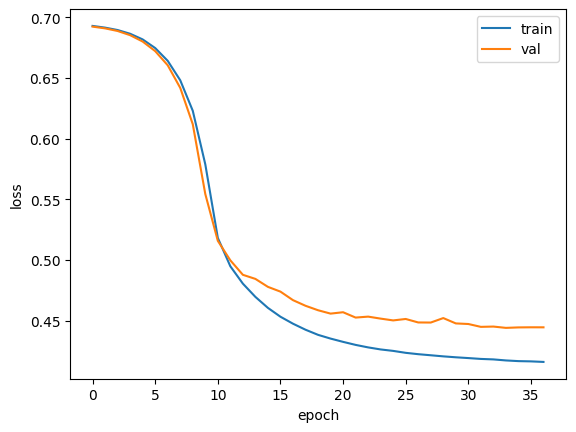

In [14]:
# 손실 그래프 그리기

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()